# Optimizing the KSD

In [1]:
from jax import config
config.update("jax_debug_nans", True)

import sys
import os
sys.path.append("/home/lauro/code/msc-thesis/svgd/kernel_learning/")
import json_tricks as json
import copy
from functools import partial

from tqdm import tqdm
import jax.numpy as np
from jax import grad, jit, vmap, random, lax, jacfwd, value_and_grad
from jax import lax
from jax.ops import index_update, index
import matplotlib.pyplot as plt
import numpy as onp
import jax
import pandas as pd
import haiku as hk
from jax.experimental import optimizers

import config

import utils
import metrics
import time
import plot
import stein
import kernels
import svgd
import distributions
import nets
import kernel_learning

from jax.experimental import optimizers

key = random.PRNGKey(0)

/home/lauro/.virtualenvs/msc-thesis/lib/python3.8/site-packages/jax/lib/xla_bridge.py:125: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


In [2]:
# estimate KSD and Var(\hat KSD) values for base kernels
def estimate_ksd_and_stddev(n: int, m: int, kernels, proposal, target):
    """
    n: number of particles
    m: number of draws for variance estimation
    kernels: list of kernel functions
    
    Returns
    ksds: mean ksd value for each kernel
    stds: standard dev for each kernel
    """
    ksds_list = [[] for kernel in kernels]
    @partial(jit, static_argnums=1)
    def sample_ksd(samples, kernel):
        return stein.ksd_squared_u(samples, target.logpdf, kernel, False)
    for _ in tqdm(range(m)):
        samples = proposal.sample(n)
        for kernel_ksds, kernel in zip(ksds_list, kernels):
            ksd = sample_ksd(samples, kernel)
            kernel_ksds.append(ksd)
    
    ksds = onp.mean(ksds_list, axis=1)
    stds = onp.std(ksds_list, axis=1)
    return ksds, stds

#### Plot everything

In [3]:
def plot_training(training_ksds, ksds, stds, ax=None, lims=None):
    if ax is None:
        ax = plt.gca()
    grid_ksds = np.asarray(training_ksds)
    ax.plot(grid_ksds, "--k", label="Optimized KSD")

    labels = ("k(x, y)=1 constant", "RBF with bandwidth 1", "RBF composed with funnel")
    cycle = iter(plt.rcParams['axes.prop_cycle'].by_key()['color'])
    for label, ksd, std, errorbar_xpos in zip(labels, ksds, stds, len(grid_ksds)*np.array([1/3, 2/3, 0.9])):
        col = next(cycle)
        ax.axhline(y=ksd, label=label, color=col, linestyle="--")
        ax.errorbar(errorbar_xpos, ksd, yerr=std, color=col, capsize=5, label="Standard deviation")
    ax.set_xlabel("Steps")
    ax.set_ylabel("KSD")

    ax.set_ylim(lims)
    _ = ax.legend()

### Parameters

In [4]:
# proposal = distributions.Gaussian(0, 1)
# target = distributions.Gaussian(0, 25)
# sizes = [16, 32, 32, 16, 2]

proposal = distributions.Uniform([[-0.5, 0.5], [-2, 2]])
# target = distributions.Funnel(2)
target = distributions.Gaussian([0, 0], 10)
sizes = [2, 2, 2]

# plot.plot_fun(target.pdf, (-10, 10), label="Target")
# plot.plot_fun(proposal.pdf, (-10, 10))
# plt.legend()

### Train

In [5]:
learning_rate = 0.1
learner = kernel_learning.KernelLearner(key, target, sizes, kernels.get_rbf_kernel(1), learning_rate, 0)

## train in isolation 

In [6]:
print("Training kernel to optimize KSD...")
learner.train(proposal, n_steps=100, batch_size=400, sample_every=True)

Training kernel to optimize KSD...


100%|██████████| 100/100 [00:10<00:00,  9.79it/s]


In [7]:
loss_mean, loss_std = learner.compute_final_loss_mean_and_stddev(proposal, batch_size=400)

print("Computing KSDs with base kernels for comparison...")
kernel_list = [kernels.constant_kernel, kernels.get_rbf_kernel(1)]
if isinstance(target, distributions.Funnel):
    kernel_list.append(kernels.get_funnel_kernel(1))
ksds, stds = onp.array(estimate_ksd_and_stddev(400, 50, kernel_list, 
                                              proposal, target))

  0%|          | 0/50 [00:00<?, ?it/s]

Computing KSDs with base kernels for comparison...


100%|██████████| 50/50 [00:03<00:00, 13.62it/s]


In [8]:
# fig, ax = plt.subplots(figsize=[10,8])
# bandwidths = np.squeeze(np.array(learner.rundata["bandwidth"]))
# plt.plot(bandwidths, "--o", label="Bandwidth", color="green")
# plt.axhline(onp.mean(bandwidths[-5:]))
# plt.yscale("log")
# plt.legend()

Plot results:
Loss std is 0.15698261559009552
KSD mean is 1.8180241584777832


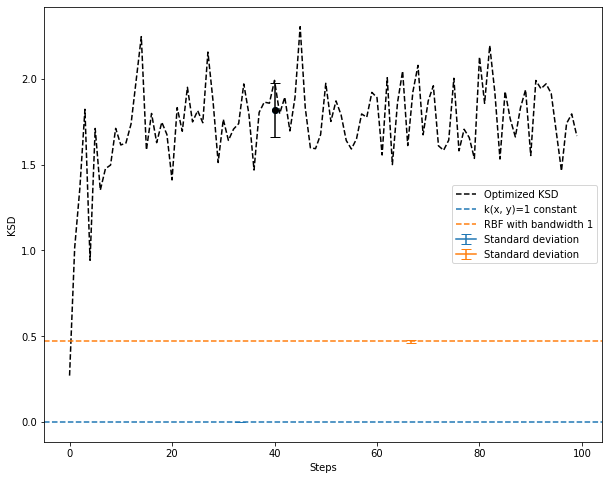

In [9]:
print("Plot results:")
fig, ax = plt.subplots(figsize=[10,8])
plot_training(learner.rundata["training_ksd"], ksds, stds, ax)
# plt.plot(learner.autoenc_losses, label="Autoencoder loss", color="purple")

plt.legend()
_ = ax.errorbar(40, -loss_mean, yerr=loss_std, capsize=5, color="k", fmt="--o")

plt.plot([40], [-loss_mean], marker="o")
print(f"Loss std is {loss_std}")
print(f"KSD mean is {-loss_mean}")

## plot learned kernel

In [10]:
params = learner.opt.get_params(learner.optimizer_state)
learned_kernel = learner.get_kernel(params)

In [11]:
s = proposal.sample(100)
learned_kernel(s[4], s[10])

DeviceArray(0.04837288, dtype=float32)

# Plot the kernel

In [12]:
bandwidths[-1]

NameError: name 'bandwidths' is not defined

In [ ]:
if proposal.d == 1:
    ngrid = 10**4
    grid = np.linspace(-4, 10, ngrid).reshape(ngrid,1)
    x = np.array([0.])
    plt.plot(grid, vmap(learned_kernel, (0, None))(grid, x), label="Learned", color="r")
    plt.plot(grid, vmap(kernels.get_rbf_kernel(1),  (0, None))(grid, x), label="RBF", color="b")
    x = np.array([4.])
    plt.plot(grid, vmap(learned_kernel, (0, None))(grid, x), color="r")
    plt.plot(grid, vmap(kernels.get_rbf_kernel(1),  (0, None))(grid, x), color="b")

    plt.legend()
elif proposal.d == 2:
    fig, ax = plt.subplots(figsize=[7,7])
    x = np.array([0, 0])
    def kernfunx(x_): return learned_kernel(x, x_)
#     def rbfx(x_): return kernels.get_rbf_kernel(1)(x, x_)
    plot.plot_pdf_2d(kernfunx, lims=(-10, 10), label="Learned Kernel", ax=ax)
#     plot.plot_pdf_2d(rbfx, lims=(-10, 10), label="RBF", ax=ax)